In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import layers
import random as rand
import sklearn.model_selection
from keras.regularizers import l1
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels_pd = pd.read_csv("/content/drive/MyDrive/labels.csv")
counts_pd = pd.read_csv("/content/drive/MyDrive/processed_counts.csv")

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [ ]:
labels_pd.columns

Index(['index', 'bulk_labels'], dtype='object')

In [ ]:
# reset the index here; will make it easier later
labels_pd = labels_pd.set_index('index')
counts_pd = counts_pd.set_index('Unnamed: 0')

In [ ]:
# shuffle together 
cell_bc = [i for i in labels_pd.index]
rand.shuffle(cell_bc)

labels_pd_shuffle = pd.DataFrame(labels_pd, index=cell_bc)
counts_pd_shuffle =  pd.DataFrame(counts_pd, index=cell_bc)

In [ ]:
# split into train and test sets
split = sklearn.model_selection.train_test_split(counts_pd_shuffle, labels_pd_shuffle, test_size=0.2)
cell_label_X_train, cell_label_X_test, cell_label_Y_train, cell_label_Y_test = split

In [ ]:
print(cell_label_X_test.shape)
print(cell_label_Y_test.shape)
print(cell_label_X_train.shape)
print(cell_label_Y_train.shape)

(140, 765)
(140, 1)
(560, 765)
(560, 1)


Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [ ]:
input_layer = 765
hidden_layer = 128
code_layer = 32

# Neural Network
input = keras.layers.Input(shape=(input_layer, ))
hidden_1 = keras.layers.Dense(hidden_layer, activation='relu')(input)
hidden_2 = keras.layers.Dense(hidden_layer, activation='relu')(hidden_1)
code = keras.layers.Dense(code_layer, activation='relu', activity_regularizer=l1(10e-6))(hidden_2)
hidden_3 = keras.layers.Dense(hidden_layer, activation='relu')(code)
hidden_4 = keras.layers.Dense(hidden_layer, activation='relu')(hidden_3)
output = keras.layers.Dense(input_layer, activation='relu')(hidden_4)

# Autoencoder 
autoencoder = keras.models.Model(input, output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(cell_label_X_train, cell_label_X_train, epochs=10)

Epoch 1/10
18/18 [==============================] - 1s 4ms/step - loss: 1.0068
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 1.0174
Epoch 3/10
18/18 [==============================] - 0s 5ms/step - loss: 0.9765
Epoch 4/10
18/18 [==============================] - 0s 5ms/step - loss: 0.9481
Epoch 5/10
18/18 [==============================] - 0s 5ms/step - loss: 0.9244
Epoch 6/10
18/18 [==============================] - 0s 5ms/step - loss: 0.9146
Epoch 7/10
18/18 [==============================] - 0s 5ms/step - loss: 0.9331
Epoch 8/10
18/18 [==============================] - 0s 5ms/step - loss: 0.9002
Epoch 9/10
18/18 [==============================] - 0s 5ms/step - loss: 0.8886
Epoch 10/10
18/18 [==============================] - 0s 4ms/step - loss: 0.8724


Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [ ]:
# latent size = 32, with regularization, 0.9 MSE loss cutoff
loss = autoencoder.evaluate(cell_label_X_test, cell_label_X_test, verbose=2)

print('Test loss:', loss)

5/5 - 0s - loss: 0.8639
Test loss: 0.8639460206031799


In [ ]:
# now train on all of the data 
autoencoder_all = keras.models.Model(input, output)
autoencoder_all.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_all.fit(counts_pd, counts_pd, epochs=10)

Epoch 1/10
22/22 [==============================] - 1s 5ms/step - loss: 0.8637
Epoch 2/10
22/22 [==============================] - 0s 5ms/step - loss: 0.8519
Epoch 3/10
22/22 [==============================] - 0s 5ms/step - loss: 0.8404
Epoch 4/10
22/22 [==============================] - 0s 5ms/step - loss: 0.8359
Epoch 5/10
22/22 [==============================] - 0s 4ms/step - loss: 0.8346
Epoch 6/10
22/22 [==============================] - 0s 5ms/step - loss: 0.8141
Epoch 7/10
22/22 [==============================] - 0s 5ms/step - loss: 0.8236
Epoch 8/10
22/22 [==============================] - 0s 5ms/step - loss: 0.8088
Epoch 9/10
22/22 [==============================] - 0s 4ms/step - loss: 0.8060
Epoch 10/10
22/22 [==============================] - 0s 4ms/step - loss: 0.7941


Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

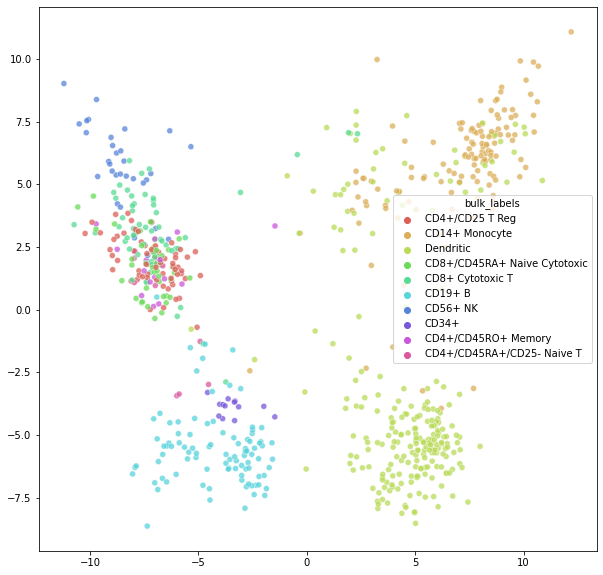

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(counts_pd_shuffle)

# Visualize X_pca

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=labels_pd_shuffle['bulk_labels'],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()

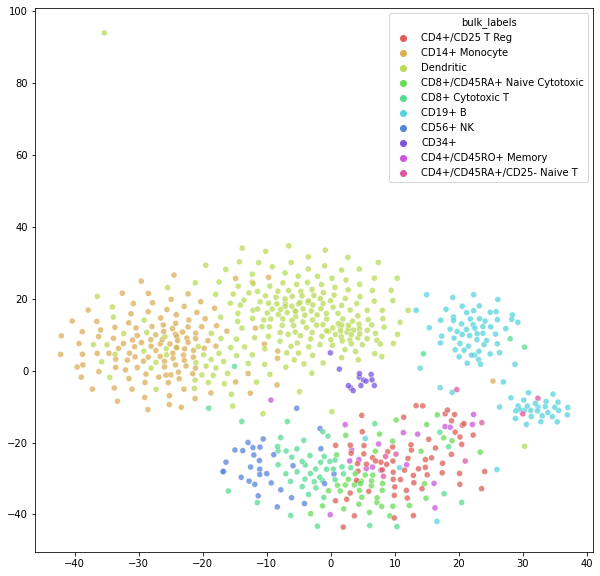

In [ ]:
tsne = TSNE()
X_tsne = tsne.fit_transform(counts_pd_shuffle)

# Visualize X_tsne

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=labels_pd_shuffle['bulk_labels'],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)

plt.show()

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.

In [ ]:
# PCA on latent representation of the data 
model_latent = keras.models.Model(input, code)
latent = model_latent.predict(counts_pd_shuffle)

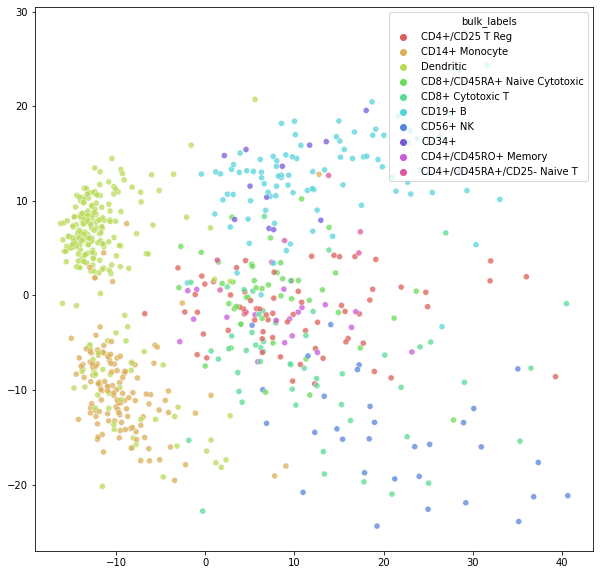

In [ ]:
latent_PCA = pca.fit_transform(latent)

# Visualize latent_PCA

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=latent_PCA[:,0], y=latent_PCA[:,1],
    hue=labels_pd_shuffle['bulk_labels'],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()

Write up:

To create the autoencoder, I decided follow a 'sandwhich-like' approach. That is, the encoder and decoder mirror each other across the 'code' layer or the latent representation of the input. Both the enoder and decoder, therefore, contain the same layers and put together create a fully-connected neural network. To decrease loss, I added more than one hidden layer and added l1 regularization in my code layer for sparcity as suggested. I also found that using 'relu' for my activation function is better compared 'sigmoid' which makes sense since a sigmoid function is better for for a binary classification which is not the case for this dataset. I also found that training for more than 15 epochs tends to overfit the training data so I settled for 10 epochs. I played around with the parameters until the loss for my testing set was less than that of the training set and that is the model that I decided to go with. Visually, it would seem like t-SNE is the best approach for dimensionality reduction for this dataset. PCA on the entire data set is also better than the PCA for the latent space. This could be due to the information that is lost when encoding. It would be interesting to see if the PCA on the output of the autoencoder is similar to the results when performing PCA on the original dataset. 